## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему. 

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv` 

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from implicit.als import AlternatingLeastSquares
import scipy.sparse as sp
from xgboost import XGBRanker
import shap
from sklearn.metrics.pairwise import cosine_similarity
import datetime

d:\HSE\Recsis_1(3-4)\DZ3\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# скачиваем данные
# если из этой ячейки не получается, то вот ссылка на папку https://drive.google.com/drive/folders/1HT0Apm8Jft0VPLJtdBBUGu9s1M7vZcoJ?usp=drive_link

!pip3 install gdown


import gdown
# train
url = "https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-"

output = 'train.csv'
gdown.download(url, output, quiet=True)

# test
url = "https://drive.google.com/uc?id=11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG"

output = 'test.csv'
gdown.download(url, output, quiet=True)

# user features
url = "https://drive.google.com/uc?id=1zl2jWMdUhc-IMakHlihQhJ5PGGZm9-_O"
output = 'users.csv'
gdown.download(url, output, quiet=True, fuzzy=True)

# item features
url = "https://drive.google.com/uc?id=1chCmpiCKJRjdqNftHc-t2ALl3qbAp2G8"
output = 'items.csv'
gdown.download(url, output, quiet=True)

Downloading...
From: https://drive.google.com/file/d/1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-/view?usp=drive_link
To: d:\HSE\Recsis_1(3-4)\DZ3\train.csv
91.9kB [00:00, 3.72MB/s]
Downloading...
From: https://drive.google.com/file/d/11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG/view?usp=drive_link
To: d:\HSE\Recsis_1(3-4)\DZ3\test.csv
92.1kB [00:00, 3.41MB/s]


'test.csv'

In [2]:
users_df = pd.read_csv('users.csv')
items_df = pd.read_csv('items.csv')



### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно. 

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**

In [3]:
# Загрузка данных
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df['last_watch_dt'] = pd.to_datetime(train_df.last_watch_dt)
test_df['last_watch_dt'] = pd.to_datetime(test_df.last_watch_dt)

In [5]:
train_df['last_watch_dt'].max()

Timestamp('2021-08-12 00:00:00')

In [6]:
# Преобразование временных меток
train_df['weekday'] = train_df.last_watch_dt.dt.weekday
test_df['weekday'] = test_df.last_watch_dt.dt.weekday
train_df = train_df.sort_values('last_watch_dt')
test_df = test_df.sort_values('last_watch_dt')


train_stage_1 = train_df.loc[(train_df.last_watch_dt < '2021-08-06')].copy()
valid_stage_1 = train_df.loc[train_df.last_watch_dt >= '2021-08-06'].copy()

user_ids = train_df['user_id'].unique()
item_ids = train_df['item_id'].unique()
user_to_idx = {user: idx for idx, user in enumerate(user_ids)}
idx_to_user = {idx: user for user, idx in user_to_idx.items()}
item_to_idx = {item: idx for idx, item in enumerate(item_ids)}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}

In [7]:
test_df.shape, train_stage_1.shape, valid_stage_1.shape

((608467, 7), (4473822, 7), (393134, 7))

In [8]:
train_grouped = train_stage_1.groupby('user_id').apply(
    lambda x: [(t1, t2, t3) for t1, t2, t3 in sorted(zip(x.item_id, 
                                                 x.last_watch_dt,
                                                 x.weekday), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_stage_1'}, axis=1, inplace=True)

valid_grouped = valid_stage_1.groupby('user_id').apply(
    lambda x: [(t1, t2, t3) for t1, t2, t3 in sorted(zip(x.item_id,
                                                         x.last_watch_dt,
                                                         x.weekday), key=lambda x: x[1])]
).reset_index()
valid_grouped.rename({0:'valid_stage_1'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2, t3) for t1, t2, t3 in sorted(zip(x.item_id,
                                                         x.last_watch_dt,
                                                         x.weekday), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_df'}, axis=1, inplace=True)

joined = train_grouped.merge(valid_grouped).merge(test_grouped)
joined.head()

C:\Users\user\AppData\Local\Temp\ipykernel_19716\3729787385.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_stage_1.groupby('user_id').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_19716\3729787385.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valid_grouped = valid_stage_1.groupby('user_id').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_19716\3729787385.py:15: Depreca

,user_id,train_stage_1,valid_stage_1,test_df
0,3,"[(2657, 2021-06-03 00:00:00, 3), (3734, 2021-0...","[(15719, 2021-08-11 00:00:00, 2), (12192, 2021...","[(142, 2021-08-13 00:00:00, 4), (965, 2021-08-..."
1,17,"[(3734, 2021-08-01 00:00:00, 6)]","[(10196, 2021-08-06 00:00:00, 4), (8618, 2021-...","[(9342, 2021-08-15 00:00:00, 6)]"
2,30,"[(4740, 2021-06-09 00:00:00, 2), (676, 2021-06...","[(3031, 2021-08-11 00:00:00, 2), (16484, 2021-...","[(15363, 2021-08-13 00:00:00, 4), (11253, 2021..."
3,47,"[(13865, 2021-07-29 00:00:00, 3), (13361, 2021...","[(12681, 2021-08-09 00:00:00, 0), (12846, 2021...","[(14488, 2021-08-20 00:00:00, 4)]"
4,53,"[(7571, 2021-07-01 00:00:00, 3), (13865, 2021-...","[(12250, 2021-08-10 00:00:00, 1)]","[(16426, 2021-08-15 00:00:00, 6), (1445, 2021-..."


In [9]:
def ndcg_metric(gt_items, predicted):
    
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    rank_dcg = dcg(relevance)

    if rank_dcg == 0.0:
        return 0.0

    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores):
    return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
                  dtype=np.float64)


def recall_metric(gt_items, predicted):
    
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt



def evaluate_recommender(df, model_preds, gt_col='test_df', topn=10):
    
    metric_values = []
    
    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        metric_values.append((ndcg_metric(gt_items, row[model_preds]),
                              recall_metric(gt_items, row[model_preds])))
        
    return {'ndcg':np.mean([x[0] for x in metric_values]),
            'recall':np.mean([x[1] for x in metric_values])}

In [10]:
class TopPopular:
    def __init__(self, default_score=0.0):
        self.trained = False
        self.default_score = default_score

    def fit(self, df, col='train_stage_1'):
        counts = {}
        for _, row in df.iterrows():
            for item, _, _ in row[col]:
                counts[item] = counts.get(item, 0) + 1

        self.recommendations = [item for item, _ in sorted(counts.items(), key=lambda x: x[1], reverse=True)]
        self.item2score = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
        self.trained = True

    def predict(self, df, topn=10) -> list:
        assert self.trained
        all_recs = []

        for _, row in df.iterrows():
            user_items = set([x[0] for x in row['train_stage_1']] + [x[0] for x in row['valid_stage_1']])
            recs = [item for item in self.recommendations if item not in user_items][:topn]
            all_recs.append(recs)

        return all_recs
    
    def predict_score(self, user_items_pairs):
        assert self.trained, "Model must be trained first"
        
        scores = []
        for user, item in user_items_pairs:
            score = self.item2score.get(item, self.default_score)
            scores.append(score)
            
        return scores

In [11]:
class ALSRecommender:
    def __init__(self, factors=50, regularization=0.01, iterations=15, default_score=0.0):
        self.model = AlternatingLeastSquares(factors=factors, regularization=regularization, iterations=iterations)
        self.user_mapping = {}
        self.item_mapping = {}
        self.user_inv_mapping = {}
        self.item_inv_mapping = {}
        self.trained = False
        self.default_score = default_score

    def fit(self, df):
        interactions = []
        user_set, item_set = set(), set()

        for _, row in df.iterrows():
            user = row['user_id']
            for item, _, _ in row['train_stage_1']:
                interactions.append((user, item, 1))
                user_set.add(user)
                item_set.add(item)

        self.user_mapping = {user: idx for idx, user in enumerate(sorted(user_set))}
        self.item_mapping = {item: idx for idx, item in enumerate(sorted(item_set))}
        self.user_inv_mapping = {idx: user for user, idx in self.user_mapping.items()}
        self.item_inv_mapping = {idx: item for item, idx in self.item_mapping.items()}

        user_ids = [self.user_mapping[u] for u, i, v in interactions]
        item_ids = [self.item_mapping[i] for u, i, v in interactions]
        values = [v for u, i, v in interactions]

        user_item_matrix = sp.coo_matrix((values, (user_ids, item_ids)))
        self.model.fit(user_item_matrix)
        self.trained = True
        self.user_item_matrix = user_item_matrix.tocsr()

    def predict(self, df, topn=10) -> list:
        assert self.trained
        recs = []

        for _, row in df.iterrows():
            uid = row['user_id']
            if uid not in self.user_mapping:
                recs.append([])
                continue

            user_idx = self.user_mapping[uid]
            user_row = self.user_item_matrix[user_idx]

            item_ids, _ = self.model.recommend(
                userid=user_idx,
                user_items=user_row,
                N=topn
            )

            rec_items = [self.item_inv_mapping[iid] for iid in item_ids]
            recs.append(rec_items)

        return recs
    
    def predict_score(self, user_items_pairs):
        assert self.trained, "Model must be trained first!"
        
        scores = []
        for user, item in user_items_pairs:
            if user not in self.user_mapping or item not in self.item_mapping:
                scores.append(self.default_score)
                continue
            
            user_idx = self.user_mapping[user]
            item_idx = self.item_mapping[item]
            
            score = np.dot(self.model.user_factors[user_idx], 
                        self.model.item_factors[item_idx])
            scores.append(score)
        
        return scores

In [12]:
class SimpleNNRecommender(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=64):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, emb_dim)
        self.item_embedding = nn.Embedding(num_items, emb_dim)

    def forward(self, user_ids, item_ids):
        u_emb = self.user_embedding(user_ids)
        i_emb = self.item_embedding(item_ids)
        return (u_emb * i_emb).sum(dim=1)

class NNRecommenderWrapper:
    def __init__(self, emb_dim=64, lr=1e-2, epochs=3, batch_size=1024, default_score=0.0):
        self.emb_dim = emb_dim
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.trained = False
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.default_score = default_score

    def fit(self, df):
        interactions = []
        user_set, item_set = set(), set()

        for _, row in df.iterrows():
            user = row['user_id']
            for item, _, _ in row['train_stage_1']:
                interactions.append((user, item, 1))
                user_set.add(user)
                item_set.add(item)

        self.user_mapping = {user: idx for idx, user in enumerate(sorted(user_set))}
        self.item_mapping = {item: idx for idx, item in enumerate(sorted(item_set))}
        self.user_inv_mapping = {idx: user for user, idx in self.user_mapping.items()}
        self.item_inv_mapping = {idx: item for item, idx in self.item_mapping.items()}

        users = torch.tensor([self.user_mapping[u] for u, i, _ in interactions], device=self.device)
        items = torch.tensor([self.item_mapping[i] for u, i, _ in interactions], device=self.device)
        labels = torch.ones(len(interactions), device=self.device)

        dataset = TensorDataset(users, items, labels)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        self.model = SimpleNNRecommender(len(self.user_mapping), len(self.item_mapping), self.emb_dim).to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        loss_fn = nn.BCEWithLogitsLoss()
        
        for epoch in range(self.epochs):
            total_loss = 0
            for batch_users, batch_items, batch_labels in tqdm(dataloader, desc=f'Epoch {epoch+1}'):
                optimizer.zero_grad()
                preds = self.model(batch_users, batch_items)
                loss = loss_fn(preds, batch_labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f'Epoch {epoch+1}, Avg Loss: {total_loss/len(dataloader):.4f}')

        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        results = []
        
        with torch.no_grad():
            user_emb = self.model.user_embedding.weight.data
            item_emb = self.model.item_embedding.weight.data
            scores = torch.matmul(user_emb, item_emb.T)
            _, top_indices = torch.topk(scores, topn, dim=1)
            
            for _, row in df.iterrows():
                uid = row['user_id']
                if uid not in self.user_mapping:
                    results.append([])
                    continue
                    
                user_idx = self.user_mapping[uid]
                top_items = top_indices[user_idx].tolist()
                results.append([self.item_inv_mapping[i] for i in top_items])
        
        return results
    
    def predict_score(self, user_items_pairs):
        assert self.trained, "Model must be trained first!"
        
        scores = []
        unknown_pairs = [] 
        
        with torch.no_grad():
            for user, item in user_items_pairs:
                if user not in self.user_mapping or item not in self.item_mapping:
                    scores.append(self.default_score)
                    unknown_pairs.append((user, item))
                    continue
                
                user_idx = torch.tensor([self.user_mapping[user]], device=self.device)
                item_idx = torch.tensor([self.item_mapping[item]], device=self.device)
                
                score = self.model(user_idx, item_idx).sigmoid().item() 
                scores.append(score)
        
        return scores

In [13]:
toppop = TopPopular()
toppop.fit(joined)
joined['toppopular_recs'] = toppop.predict(joined)
print("TopPopular:", evaluate_recommender(joined, model_preds='toppopular_recs'))
    
als = ALSRecommender()
als.fit(joined)
joined['als_recs'] = als.predict(joined)
print("ALSRecommender", evaluate_recommender(joined, model_preds='als_recs'))

nn_ = NNRecommenderWrapper()
nn_.fit(joined)
joined['nn_recs'] = nn_.predict(joined)
print("NNRecommenderWrapper", evaluate_recommender(joined, model_preds='nn_recs'))

joined.head()       

TopPopular: {'ndcg': np.float64(0.19191215429999606), 'recall': np.float64(0.11729813019562099)}


d:\HSE\Recsis_1(3-4)\DZ3\.venv\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
d:\HSE\Recsis_1(3-4)\DZ3\.venv\lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.028015851974487305 seconds
  warnings.warn(
100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


ALSRecommender {'ndcg': np.float64(0.0857506008653036), 'recall': np.float64(0.04408707829291198)}


Epoch 1: 100%|██████████| 816/816 [00:37<00:00, 21.49it/s]


Epoch 1, Avg Loss: 2.4058


Epoch 2: 100%|██████████| 816/816 [00:35<00:00, 22.75it/s]


Epoch 2, Avg Loss: 0.4906


Epoch 3: 100%|██████████| 816/816 [00:39<00:00, 20.77it/s]


Epoch 3, Avg Loss: 0.0380
NNRecommenderWrapper {'ndcg': np.float64(0.000350650621811183), 'recall': np.float64(0.0001667073380114277)}


,user_id,train_stage_1,valid_stage_1,test_df,toppopular_recs,als_recs,nn_recs
0,3,"[(2657, 2021-06-03 00:00:00, 3), (3734, 2021-0...","[(15719, 2021-08-11 00:00:00, 2), (12192, 2021...","[(142, 2021-08-13 00:00:00, 4), (965, 2021-08-...","[15297, 13865, 142, 9996, 8636, 4495, 7829, 75...","[12324, 6443, 14431, 10077, 16509, 12356, 9103...","[13931, 2531, 10862, 12999, 419, 15749, 3590, ..."
1,17,"[(3734, 2021-08-01 00:00:00, 6)]","[(10196, 2021-08-06 00:00:00, 4), (8618, 2021-...","[(9342, 2021-08-15 00:00:00, 6)]","[10440, 9728, 15297, 13865, 4151, 4880, 2657, ...","[456, 15171, 13262, 6646, 3076, 14095, 11756, ...","[5730, 5083, 11743, 3102, 15787, 8121, 1099, 1..."
2,30,"[(4740, 2021-06-09 00:00:00, 2), (676, 2021-06...","[(3031, 2021-08-11 00:00:00, 2), (16484, 2021-...","[(15363, 2021-08-13 00:00:00, 4), (11253, 2021...","[10440, 15297, 13865, 3734, 4151, 4880, 2657, ...","[6162, 10464, 12356, 1418, 657, 10240, 9103, 8...","[11609, 8432, 5015, 6852, 9142, 9157, 2394, 10..."
3,47,"[(13865, 2021-07-29 00:00:00, 3), (13361, 2021...","[(12681, 2021-08-09 00:00:00, 0), (12846, 2021...","[(14488, 2021-08-20 00:00:00, 4)]","[10440, 9728, 15297, 3734, 4151, 4880, 2657, 1...","[11749, 6774, 4475, 4436, 15266, 14317, 1449, ...","[14656, 16199, 11813, 8272, 5286, 4656, 2189, ..."
4,53,"[(7571, 2021-07-01 00:00:00, 3), (13865, 2021-...","[(12250, 2021-08-10 00:00:00, 1)]","[(16426, 2021-08-15 00:00:00, 6), (1445, 2021-...","[9728, 4880, 2657, 9996, 8636, 4495, 7829, 680...","[4716, 7107, 13915, 5732, 1132, 1916, 12537, 1...","[13711, 5695, 1081, 14164, 9924, 5988, 15736, ..."


In [14]:
def intra_list_diversity(recommended_lists, item_embeddings):
    diversities = []

    for items in recommended_lists:
        if len(items) < 2:
            diversities.append(0.0)
            continue

        embeddings = np.array([item_embeddings[item] for item in items if item in item_embeddings])
        if len(embeddings) < 2:
            diversities.append(0.0)
            continue

        sim_matrix = cosine_similarity(embeddings)
        upper_triangle_indices = np.triu_indices_from(sim_matrix, k=1)
        mean_similarity = np.mean(sim_matrix[upper_triangle_indices])
        diversity = 1 - mean_similarity  
        diversities.append(diversity)

    return np.mean(diversities)

unique_items = set(x for rec in joined['toppopular_recs'] for x in rec)
dummy_emb = np.zeros(10)
toppop_item_embeddings = {item: dummy_emb for item in unique_items}

als_item_embs = als.model.item_factors
als_item_id_map = als.item_inv_mapping
als_item_embeddings = {als_item_id_map[idx]: emb for idx, emb in enumerate(als_item_embs)}

nn_item_embs = nn_.model.item_embedding.weight.data.cpu().numpy()
nn_item_id_map = nn_.item_inv_mapping
nn_item_embeddings = {nn_item_id_map[idx]: emb for idx, emb in enumerate(nn_item_embs)}

div_toppop = intra_list_diversity(joined['toppopular_recs'], toppop_item_embeddings)
div_als = intra_list_diversity(joined['als_recs'], als_item_embeddings)
div_nn = intra_list_diversity(joined['nn_recs'], nn_item_embeddings)
print(f"Diversity TopPopular: {div_toppop:.4f}")
print(f"Diversity ALS: {div_als:.4f}")
print(f"Diversity NN: {div_nn:.4f}")

Diversity TopPopular: 1.0000
Diversity ALS: 0.6501
Diversity NN: 0.8401



### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)). 

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

In [15]:
def generate_features(df, reference_date):
    df_features = df.copy()
    # Признаки пользователя (например, среднее watched_pct до reference_date)
    user_mean = train_df[train_df['last_watch_dt'] < reference_date].groupby('user_id')['watched_pct'].mean().reset_index().rename(columns={'watched_pct': 'user_mean_watch'})
    # Признак пользователя: число просмотренных айтемов
    user_count = train_df[train_df['last_watch_dt'] < reference_date].groupby('user_id').size().reset_index(name='user_count')
    # Признаки айтема (например, среднее watched_pct для айтема)
    item_mean = train_df[train_df['last_watch_dt'] < reference_date].groupby('item_id')['watched_pct'].mean().reset_index().rename(columns={'watched_pct': 'item_mean_watch'})
    # Признак айтема: число просмотров
    item_count = train_df[train_df['last_watch_dt'] < reference_date].groupby('item_id').size().reset_index(name='item_count')
    # Признаки взаимодействия: пересечение статистик пользователя и айтема
    interaction = train_df[train_df['last_watch_dt'] < reference_date].groupby(['user_id', 'item_id'])['watched_pct'].agg(['mean', 'count']).reset_index().rename(columns={'mean': 'user_item_mean', 'count': 'user_item_count'})
    # Объединение признаков
    df_features = df_features.merge(user_mean, on='user_id', how='left')
    df_features = df_features.merge(user_count, on='user_id', how='left')
    df_features = df_features.merge(item_mean, on='item_id', how='left')
    df_features = df_features.merge(item_count, on='item_id', how='left')
    df_features = df_features.merge(interaction, on=['user_id', 'item_id'], how='left')
    # Дополнительные признаки (для достижения 10 признаков)
    df_features['user_item_diff'] = df_features['user_mean_watch'] - df_features['item_mean_watch']
    df_features['user_item_ratio'] = df_features['user_item_count'] / (df_features['item_count']+1)
    df_features['user_watch_std'] = train_df[train_df['last_watch_dt'] < reference_date].groupby('user_id')['watched_pct'].std().reset_index(drop=True)
    df_features['item_watch_std'] = train_df[train_df['last_watch_dt'] < reference_date].groupby('item_id')['watched_pct'].std().reset_index(drop=True)
    return df_features

split_time = train_stage_1.last_watch_dt.max()
# Предположим, что valid_stage_1 начинается в первый день после split_time
valid_reference_date = (split_time + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
test_reference_date = (pd.to_datetime(test_df['last_watch_dt'].min())).strftime('%Y-%m-%d')

train_df_with_features = generate_features(valid_stage_1, valid_reference_date)
test_df_with_features = generate_features(test_df, test_reference_date)

In [16]:
train_df_with_features

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,weekday,user_mean_watch,user_count,item_mean_watch,item_count,user_item_mean,user_item_count,user_item_diff,user_item_ratio,user_watch_std,item_watch_std
0,765312,15297,2021-08-06,2492,25.0,0,4,NaN,NaN,55.894748,162667.0,NaN,NaN,NaN,NaN,1.329160,26.037493
1,758517,4718,2021-08-06,3358,60.0,1,4,20.884615,26.0,50.233549,5258.0,NaN,NaN,-29.348933,NaN,31.932633,42.042168
2,293013,11699,2021-08-06,4861,76.0,1,4,50.222222,9.0,61.430769,1170.0,NaN,NaN,-11.208547,NaN,45.034035,38.872337
3,257854,101,2021-08-06,1332,21.0,0,4,59.470588,17.0,22.796485,10014.0,NaN,NaN,36.674103,NaN,68.589358,36.175103
4,119186,2081,2021-08-06,366,6.0,0,4,2.000000,1.0,63.946868,1261.0,NaN,NaN,-61.946868,NaN,8.821348,43.209567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393129,1085638,9996,2021-08-12,20985,70.0,1,3,50.111111,9.0,28.618333,32924.0,NaN,NaN,21.492778,NaN,NaN,NaN
393130,632245,14362,2021-08-12,5921,100.0,1,3,33.250000,4.0,68.084170,1295.0,NaN,NaN,-34.834170,NaN,NaN,NaN
393131,651541,7829,2021-08-12,753,12.0,0,3,2.666667,3.0,43.584305,13380.0,NaN,NaN,-40.917638,NaN,NaN,NaN
393132,1034626,5046,2021-08-12,170,2.0,0,3,NaN,NaN,34.840215,1114.0,NaN,NaN,NaN,NaN,NaN,NaN



### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [17]:
train_pairs = list(zip(train_df_with_features['user_id'], train_df_with_features['item_id']))
test_pairs = list(zip(test_df_with_features['user_id'], test_df_with_features['item_id']))

models = {
    'toppop': toppop,
    'als': als,
    'nn': nn_
}

for name, model in models.items():
    print(f"Добавляем скоры модели {name}...")

    train_scores = model.predict_score(train_pairs)
    test_scores = model.predict_score(test_pairs)

    train_df_with_features[f'{name}_score'] = train_scores
    test_df_with_features[f'{name}_score'] = test_scores

Добавляем скоры модели toppop...
Добавляем скоры модели als...
Добавляем скоры модели nn...


In [18]:
train_df_with_features['last_watch_dt_str'] = train_df_with_features['last_watch_dt'].dt.strftime('%Y-%m-%d')
test_df_with_features['last_watch_dt_str'] = test_df_with_features['last_watch_dt'].dt.strftime('%Y-%m-%d')

all_dates = pd.concat([train_df_with_features['last_watch_dt_str'], test_df_with_features['last_watch_dt_str']])
date2label = {date: idx for idx, date in enumerate(all_dates.unique())}

train_df_with_features['last_watch_dt_encoded'] = train_df_with_features['last_watch_dt_str'].map(date2label)
test_df_with_features['last_watch_dt_encoded'] = test_df_with_features['last_watch_dt_str'].map(date2label)

features = ['item_id', 'last_watch_dt_encoded', 'weekday', 'user_mean_watch', 'user_count',
           'item_mean_watch', 'item_count', 'user_item_mean', 'user_item_count', 
           'user_item_diff', 'user_item_ratio', 'user_watch_std', 'item_watch_std', 'toppop_score', 'als_score', 'nn_score']

X_train = train_df_with_features[features]
y_train = train_df_with_features['target']
train_groups = train_df_with_features.groupby('user_id').size().values

X_test = test_df_with_features[features]
y_test = test_df_with_features['target']
test_groups = test_df_with_features.groupby('user_id').size().values

ranker = XGBRanker(
    objective='rank:pairwise',
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    random_state=42
)

ranker.fit(
    X_train,
    y_train,
    group=train_groups,
    eval_set=[(X_test, y_test)],
    eval_group=[test_groups],
    verbose=10
)

[0]	validation_0-ndcg@32:0.94266
[10]	validation_0-ndcg@32:0.94365
[20]	validation_0-ndcg@32:0.94372
[30]	validation_0-ndcg@32:0.94392
[40]	validation_0-ndcg@32:0.94402
[50]	validation_0-ndcg@32:0.94415
[60]	validation_0-ndcg@32:0.94416
[70]	validation_0-ndcg@32:0.94420
[80]	validation_0-ndcg@32:0.94421
[90]	validation_0-ndcg@32:0.94423
[99]	validation_0-ndcg@32:0.94420


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, feature_weights=None,
          gamma=None, grow_policy=None, importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=6, max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=100,
          n_jobs=None, num_parallel_tree=None, ...)

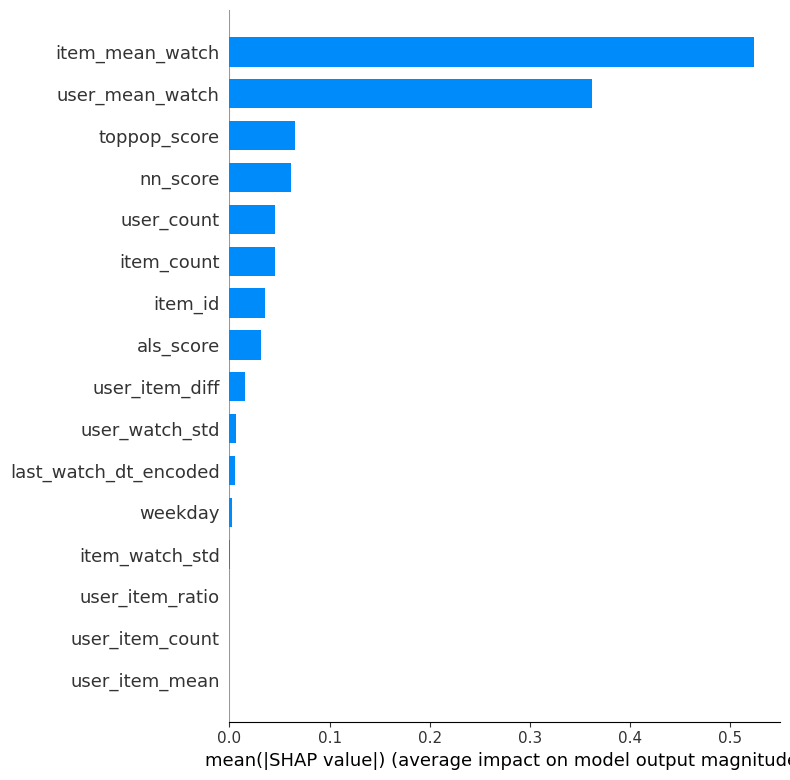

d:\HSE\Recsis_1(3-4)\DZ3\.venv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1437: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


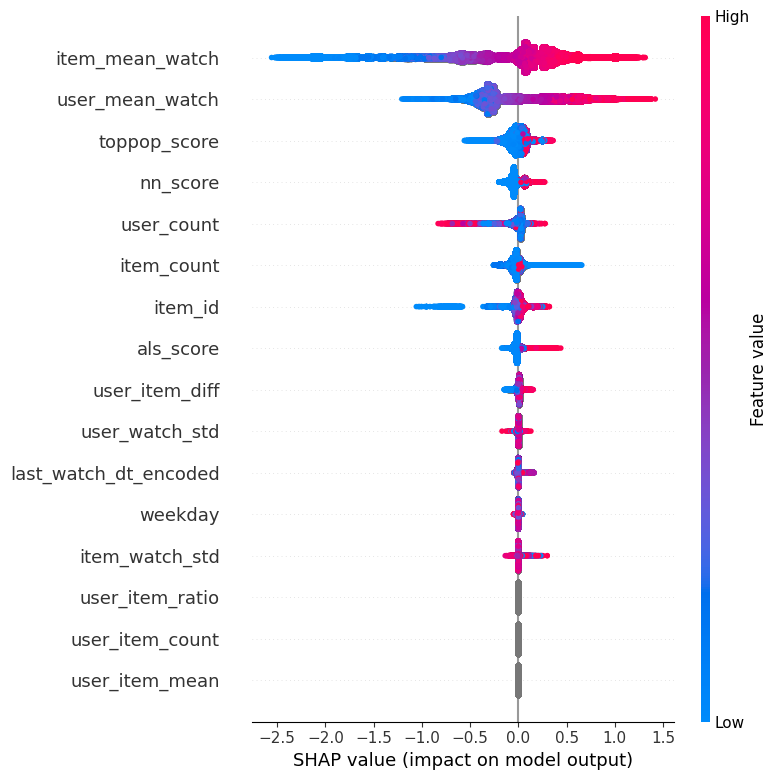

In [19]:
explainer = shap.TreeExplainer(ranker)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar') 

shap.summary_plot(shap_values, X_test)


### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

In [ ]:
# YOUR CODE HERE